# Ward Representation, Faber Algorithm
Use Ward _et al_ representation and Faber's machine learning algorithm

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multiprocessing import Pool
from pymatgen import Element, Composition
from pymatgen.io.vasp.outputs import Poscar
from scipy import stats
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import itertools
import gzip
import json
import os

In [2]:
train_size = 1000
test_size = 20000
n_repeats = 25
pick_size = 50

## The Data
Load in a JSON file, compute the elements

In [3]:
qh_data = json.load(open(os.path.join('..','datasets','quat-heuslers.json')))

In [4]:
qh_data = pd.DataFrame(qh_data['entries'])

Get the elements

In [5]:
qh_data['elems'] = [list(Composition(x).keys()) for x in qh_data['composition']]

In [6]:
qh_elements = list(set(sum([x for x in qh_data['elems'] if x is not None], [])))
print('%d elements in space'%len(qh_elements))

54 elements in space


Get the stability

In [7]:
qh_data['stability'] = [x['measured'] for x in qh_data['class']]

## The Algorithm
This is just the algorithm from `faber-method.ipynb`, but modified to use the Ward *et al* Voronoi features. It also includes the ability to use Random-Forest-based feature selection.

In [8]:
class FaberFitter(RegressorMixin):
    
    def __init__(self, sigma=1, reg_elems=1e-6, reg_dist=1e-6, feature_selection=False):
        self.sigma = sigma
        self.reg_elems = reg_elems
        self.reg_dist = reg_dist
        self.fs = feature_selection
    
    def _compute_elem_inputs(self, X):
        output = np.zeros((len(X), len(qh_elements)))
        for i,x in enumerate(X):
            for e in x:
                output[i,qh_elements.index(e)] = 1
        return output
   
    def _compute_row(self, x):
        return [np.linalg.norm(np.subtract(y,x)) for y in self.train_set]
        
    def _compute_dist_matrix(self, X, fit_scale=False, y=None):
        # Convert data to array
        X = np.array(X.tolist())
        if fit_scale:
            # Fit scale and features
            self.scaler = StandardScaler().fit(self.train_set)
            self.train_set = list(self.scaler.transform(self.train_set))
            
            # Fit features
            if self.fs:
                self.rfe = RFE(RandomForestRegressor(), 32, 0.3).fit(self.train_set, y)
                self.train_set = list(self.rfe.transform(self.train_set))
            
        # Scale data
        X = self.scaler.transform(X)
        
        # Feature seelction
        if self.fs:
            X = self.rfe.transform(X)
        
        # Compute the distance matrix in parallel
        with Pool(None) as p:
            dists = p.map(self._compute_row, X)
        return np.array(dists)
    
    def fit(self, X, y):
        self.train_set = X['attributes'].tolist()
        elems = self._compute_elem_inputs(X['elems'])
        dist = self._compute_dist_matrix(X['attributes'], y=y, fit_scale=True)
        
        return self._fit(elems, dist, y)
    
    def tune_and_fit(self, X, y, X_test, y_test, sigmas=np.logspace(0, 8, 8), 
                    reg_elems=np.logspace(-6,2,8), reg_dist=np.logspace(-6,2,8)):
        # Precompute distance matrices
        self.train_set = X['attributes'].tolist()
        elems = self._compute_elem_inputs(X['elems'])
        dist = self._compute_dist_matrix(X['attributes'], y=y, fit_scale=True)
        
        elems_test = self._compute_elem_inputs(X_test['elems'])
        dists_test = self._compute_dist_matrix(X_test['attributes'])
        
        # Optimize the parameters
        best_params = []
        best_score = np.inf
        for s,e,d in tqdm(list(itertools.product(sigmas, reg_elems, reg_dist)), leave=False):
            # Fit the model
            self.sigma = s
            self.reg_elems = e
            self.reg_dist = d
            self._fit(elems, dist, y)
            
            # Test the model
            y_pred = self._predict(elems_test, dists_test)
            score = np.mean(np.power(y_pred - y_test, 2))
            if score < best_score:
                best_params = (s,e,d)
                best_score = score
                
        # Set the best parameters
        self.sigma = best_params[0]
        self.reg_elems = best_params[1]
        self.reg_dist = best_params[2]
        self._fit(elems, dist, y)
    
    def _fit(self, elem_matrix, dist_matrix, y):
        # Remove the element contributions
        self.elem_coeff = np.linalg.solve(
            np.dot(elem_matrix.T, elem_matrix) + np.eye(len(qh_elements)) * self.reg_elems, np.dot(elem_matrix.T, y)
        )
        y_p = y - np.dot(elem_matrix, self.elem_coeff)
        
        # Solve the kernel matrix
        kernl = np.exp(-1 * dist_matrix / self.sigma)
        self.coeff = np.linalg.solve(kernl + np.eye(*kernl.shape) * self.reg_dist, y_p)
        return self
    
    def predict(self, X):
        elems = self._compute_elem_inputs(X['elems'])
        dists = self._compute_dist_matrix(X['attributes'])
        return self._predict(elems, dists)
        
    def _predict(self, elems, dists):
        kernl = np.exp(-1 * dists / self.sigma)
        return np.dot(elems, self.elem_coeff) + np.dot(kernl, self.coeff)

## Make sure the models works
We want to see a reasonable $R^2$

In [9]:
train_data, test_data = train_test_split(qh_data, train_size=train_size, test_size=train_size)

In [10]:
model = FaberFitter(feature_selection=True)
model.tune_and_fit(train_data, train_data['stability'], test_data, test_data['stability'])

Widget Javascript not detected.  It may not be installed or enabled properly.


In [11]:
print('Best sigma:', model.sigma)

Best sigma: 2682.69579528


In [12]:
predictions = model.predict(test_data)

R: 0.862677443717


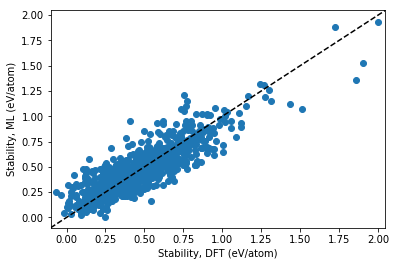

In [13]:
fig, ax = plt.subplots()

ax.scatter(test_data['stability'], predictions)
print('R:', np.corrcoef(predictions, test_data['stability'])[0][1])

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Stability, DFT (eV/atom)')
ax.set_ylabel('Stability, ML (eV/atom)')

## Do the CV Test

In [14]:
def run_test(i):
    train_data, test_data = train_test_split(qh_data, train_size=train_size, test_size=test_size, random_state=i)
    
    model.fit(train_data, train_data['stability'])
    test_data = test_data.copy()
    test_data['prediction'] = model.predict(test_data)
    test_data.sort_values('prediction', ascending=True, inplace=True)
    return sum(test_data['stability'].iloc[:pick_size] <= 0)

In [15]:
scores = [run_test(i) for i in tqdm(range(n_repeats))]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [16]:
print(np.mean(scores), '+/-', stats.sem(scores))

6.4 +/- 0.538516480713


## CV Test without Feature Selection

In [17]:
model = FaberFitter()
model.tune_and_fit(train_data, train_data['stability'], test_data, test_data['stability'])

Widget Javascript not detected.  It may not be installed or enabled properly.


In [18]:
print('Best sigma:', model.sigma)

Best sigma: 2682.69579528


In [19]:
def run_test(i):
    train_data, test_data = train_test_split(qh_data, train_size=train_size, test_size=test_size, random_state=i)
    
    model.fit(train_data, train_data['stability'])
    test_data = test_data.copy()
    test_data['prediction'] = model.predict(test_data)
    test_data.sort_values('prediction', ascending=True, inplace=True)
    return sum(test_data['stability'].iloc[:pick_size] <= 0)

In [20]:
scores = [run_test(i) for i in tqdm(range(n_repeats))]
print(np.mean(scores), '+/-', stats.sem(scores))

Widget Javascript not detected.  It may not be installed or enabled properly.



5.08 +/- 0.454312667664


In [21]:
print(np.mean(scores), '+/-', stats.sem(scores))

5.08 +/- 0.454312667664
